<h2> Applied Data Science Capstone - Final Assignment</h2>
<h2> San Francisco COVID-19 case counts by zip code</h2>
<h2><i> Do they correlate with neighborhood venue data from Foursquare?</i></h2>
<br>

<h3> Import libraries needed</h3>

In [1]:
#import pandas, numpy, & matplotlib libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import sklearn(scikit-learn) libraries
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#import libraries for extracting/download data from web
import requests
from bs4 import BeautifulSoup
import wget

#import geocoders library
from geopy.geocoders import Nominatim

#import geo-visualization library
import folium


<h3>Define variables</h3>

In [2]:
#URL locations to download SF COVID-19 data
csvurl='https://data.sfgov.org/api/views/favi-qct6/rows.csv?accessType=DOWNLOAD'
geojsonurl = 'https://data.sfgov.org/api/geospatial/favi-qct6?method=export&format=GeoJSON'

#URL for SF zip codes with neighborhood names
sfzipurl = 'http://sanfranguide.com/zip-codes/'
useragent ='Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'

#information for Foursquare API
CLIENT_ID = 'V25OYZRTG244PPB512XXX5IA52HZPBVVREBOYUF2HCU3HZMQ' # your Foursquare ID
CLIENT_SECRET = 'EAHMU2VCDRJBIDJ5A5JRNF4FJB102GNEX20CLIPH5F5PDHZS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#folium geo coordinates and tile info
sflat = 37.7749
sflon = -122.4194
tile = 'CartoDB positron'

#percentage of data set to be used as test set in data modeling
testsize = 0.25

<h3>Download SF COVID-19 by zip code data </h3>

<p>San Francisco government data website actually has a page displaying both geo-visualization and data:</p>
<p><a href='https://data.sfgov.org/COVID-19/Map-of-Rate-of-COVID-19-Cases-by-ZIP-Code/5wiy-68dq'> https://data.sfgov.org/COVID-19/Map-of-Rate-of-COVID-19-Cases-by-ZIP-Code/5wiy-68dq</a></p>
<p>However, because this page uses embedded JavaScript to dynamically update itself, it is very hard to scrap with requests/BeautifulSoup. </p>

<p>Fortunately, the website also provides a link to download data in various formats includeing csv, so we will use wget to download that csv file.</p>

In [3]:
#use wget to download csv file
wget.download(csvurl, 'sfcovid.csv')

#put csv file into a dataframe
sfcovid_df = pd.read_csv('sfcovid.csv')

#preview shape of dataframe
print(sfcovid_df.shape)


(27, 12)


<p>Since there are only 27 zip codes with 12 columns, let's look at the entire dataframe:</p>

In [4]:
#display entire dataframe
sfcovid_df

,Data as of,OBJECTID,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,Count of San Francisco Confirmed Cases,Estimated 2017 ACS San Francisco Population,Estimated Rate of San Francisco Cases per 10k,Case Rate Difference from San Francisco,multipolygon
0,2020/05/26,2,94121,39.0,43638,8.94,5-10,2320,864263,26.84,-17.91,MULTIPOLYGON (((-122.48542599984555 37.7898249...
1,2020/05/26,4,94123,28.0,25461,11.00,10-15,2320,864263,26.84,-15.85,MULTIPOLYGON (((-122.45005999994794 37.8024729...
2,2020/05/26,13,94158,25.0,6547,38.19,35-40,2320,864263,26.84,11.34,MULTIPOLYGON (((-122.3836959998312 37.75470099...
3,2020/05/26,18,94107,122.0,29920,40.78,40-45,2320,864263,26.84,13.93,MULTIPOLYGON (((-122.38530302568738 37.7898378...
4,2020/05/26,1,94118,39.0,41417,9.42,5-10,2320,864263,26.84,-17.43,MULTIPOLYGON (((-122.44767900001601 37.7917029...
5,2020/05/26,24,94114,40.0,34561,11.57,10-15,2320,864263,26.84,-15.27,MULTIPOLYGON (((-122.4264020000664 37.76959599...
6,2020/05/26,11,94133,28.0,26942,10.39,10-15,2320,864263,26.84,-16.45,MULTIPOLYGON (((-122.4006006226119 37.80601513...
7,2020/05/26,10,94132,33.0,31155,10.59,10-15,2320,864263,26.84,-16.25,MULTIPOLYGON (((-122.47156899970116 37.7347069...
8,2020/05/26,23,94112,293.0,85373,34.32,30-35,2320,864263,26.84,7.48,MULTIPOLYGON (((-122.41545899995634 37.7321639...
9,2020/05/26,27,94117,56.0,43610,12.84,10-15,2320,864263,26.84,-14.00,MULTIPOLYGON (((-122.42992899967089 37.7779089...


<h3>Data clean up and augmentations </h3>
<p>As you can see from dataframe above, there are some zip codes that 'No Values' in Rate Group columns. However, by examing the populations in those zip codes (in 'Estimated 2017 ACS Population' column), we can see that those zip codes contain less than 5,000 people each, therefore are probably insignficant. Let's drop them from the dataframe.<p>

In [5]:
#drop rows with NaN values as they are not relevant
sfcovid_df = sfcovid_df.dropna()

<p>There are also a few columns that we won't need for the analysis, so let's also drop those columns to make the dataframe smaller.</p>

In [6]:
#drop columns not needed
sfcovid_df = sfcovid_df.drop(columns=['OBJECTID',
                                      'Count of San Francisco Confirmed Cases',
                                      'Estimated 2017 ACS San Francisco Population',
                                      'Estimated Rate of San Francisco Cases per 10k',
                                      'Case Rate Difference from San Francisco',
                                      'multipolygon'])


<p><b><u>Here's the dataframe after this minor clean up:</b></u></p>

In [7]:
#reset index
sfcovid_df.reset_index(drop=True, inplace=True)
#display entire data
sfcovid_df

,Data as of,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups
0,2020/05/26,94121,39.0,43638,8.94,5-10
1,2020/05/26,94123,28.0,25461,11.00,10-15
2,2020/05/26,94158,25.0,6547,38.19,35-40
3,2020/05/26,94107,122.0,29920,40.78,40-45
4,2020/05/26,94118,39.0,41417,9.42,5-10
5,2020/05/26,94114,40.0,34561,11.57,10-15
6,2020/05/26,94133,28.0,26942,10.39,10-15
7,2020/05/26,94132,33.0,31155,10.59,10-15
8,2020/05/26,94112,293.0,85373,34.32,30-35
9,2020/05/26,94117,56.0,43610,12.84,10-15


<p>'Rate Groups' column represents segments of COVID-19 cases per 10K population for each zip-code. Since this is the result we would like to correlate to, having this data as a text field is not ideal. There are only 12 segments, so I created a csv file matching each 'Rate Groups' item to a 'group_id' in integer format. Let's bring that csv file into a dataframe.</p>

In [8]:
#put rate group index into a data frame
rategroup = pd.read_csv('rategroupsindex.csv')

rategroup

,Rate Groups,group_id
0,0-5,0.0
1,5-10,1.0
2,10-15,2.0
3,15-20,3.0
4,20-25,4.0
5,25-30,5.0
6,30-35,6.0
7,35-40,7.0
8,40-45,8.0
9,45-50,9.0


<p>We will merge the group_id field into our main dataframe, and display first few rows to make sure it worked.</p>

In [9]:
#merge two dataframe on 'Rate Groups'
sfcovid_df = sfcovid_df.merge(rategroup, on='Rate Groups', how='left')

#display first few rows after merging
sfcovid_df.head()

,Data as of,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,group_id
0,2020/05/26,94121,39.0,43638,8.94,5-10,1.0
1,2020/05/26,94123,28.0,25461,11.00,10-15,2.0
2,2020/05/26,94158,25.0,6547,38.19,35-40,7.0
3,2020/05/26,94107,122.0,29920,40.78,40-45,8.0
4,2020/05/26,94118,39.0,41417,9.42,5-10,1.0


<p>The data is mainly based on zip codes, but having the neighborhood name for each zip code represent would be better. Finding a website that shows a grid of San Francisco neighborhoods by zip codes turned out to be a little harder than I anticipated, but I did find one that is fairly suitable. We will use request and BeautifulSoup to bring in that data.</p>

In [10]:
#use requests to get the url, then BeautifulSoup to bring in htlm content
page = requests.get(sfzipurl, headers={'User-Agent':useragent})
soup = BeautifulSoup(page.content, 'lxml')

In [11]:
#find main content
main = soup.find(id="content")

#find all divs
divs = main.find_all('div')

#initialize a dataframe for zipcode/neighborhood data
zn_list = pd.DataFrame(columns=('ZIP Code', 'Neighborhood'))

#loop through div's to find zipcode/neighborhood data
for div in divs:
    divtext = div.get_text()
    if divtext[:3] =='» 9': #this div contain zipcode/neighborhood data
        #print(divtext[2:7],divtext[10:])
        zn_list = zn_list.append({'ZIP Code':divtext[2:7],
                                  'Neighborhood':divtext[10:]},
                                ignore_index = True)    

zn_list = zn_list.astype({'ZIP Code':'int64'}) #make sure zip codes are in integer format

zn_list

,ZIP Code,Neighborhood
0,94102,Hayes Valley
1,94103,SoMa
2,94104,Financial District
3,94105,Embarcadero South
4,94107,Portrero Hill
5,94108,Chinatown
6,94109,San Francisco
7,94109,Nob Hill
8,94109,Russian Hill
9,94110,Mission District


<p>A quick browse of this zip code list shows that there are rows with duplicate zip codes. For example, 94109 appears three times. Let's consolidate duplicate zip codes by combining their neighborhood names.</p>

In [12]:
#create a new datafram
zn_list_conso = pd.DataFrame(columns=('ZIP Code', 'Neighborhood'))

prior_zip = 0
for n, curr_zip in enumerate(zn_list['ZIP Code']):
    #fetch neighborhood name
    neigh = zn_list.iloc[n,1]
  
    #check for duplicate zip code, and concat neighborhood names
    if curr_zip == prior_zip:
            neigh = neigh + '/' + zn_list_conso.iloc[n-1,1]
            
    prior_zip = curr_zip #save zip for next iteration
    
    #append zip and neighborhood into new dataframe
    zn_list_conso = zn_list_conso.append({'ZIP Code':curr_zip,
                                          'Neighborhood':neigh},
                                         ignore_index = True)

#drop duplicate zip codes
zn_list_conso.drop_duplicates(subset='ZIP Code', keep='last', inplace=True)

#dispaly dataframe
zn_list_conso
    

,ZIP Code,Neighborhood
0,94102,Hayes Valley
1,94103,SoMa
2,94104,Financial District
3,94105,Embarcadero South
4,94107,Portrero Hill
5,94108,Chinatown
8,94109,Russian Hill/Nob Hill/San Francisco
9,94110,Mission District
10,94111,Embarcadero North
11,94112,Ingleside


<p>Now that we have zip codes with neighborhood names, we will merge it into our main dataframe.</p>

In [13]:
#merge two dataframe on 'ZIP Code'
sfcovid_df = sfcovid_df.merge(zn_list_conso, on='ZIP Code', how='left')


<p>Let's take a quick look at our data frame to make sure all zip codes have neighborhood names:</p>

In [14]:
sfcovid_df

,Data as of,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,group_id,Neighborhood
0,2020/05/26,94121,39.0,43638,8.94,5-10,1.0,Outter Richmond
1,2020/05/26,94123,28.0,25461,11.00,10-15,2.0,Marina District/Cow Hollow
2,2020/05/26,94158,25.0,6547,38.19,35-40,7.0,NaN
3,2020/05/26,94107,122.0,29920,40.78,40-45,8.0,Portrero Hill
4,2020/05/26,94118,39.0,41417,9.42,5-10,1.0,Richmond District
5,2020/05/26,94114,40.0,34561,11.57,10-15,2.0,Castro
6,2020/05/26,94133,28.0,26942,10.39,10-15,2.0,Fishermans Wharf/North beach
7,2020/05/26,94132,33.0,31155,10.59,10-15,2.0,Lake Merced
8,2020/05/26,94112,293.0,85373,34.32,30-35,6.0,Ingleside
9,2020/05/26,94117,56.0,43610,12.84,10-15,2.0,Cole Valley/Height District


<p>As we can see from above, there are a couple of zip codes missing neighborhood names. As I mentioned, it was hard to find a website that listed all San Francisco zip codes with neighborhood names, and the one I found probably has not been updated since new zip codes were added in San Francisco. For convenient sake, I looked up the two zip codes online and found their neighborhood. We will add them manually.</p>

In [15]:
#add Portola and Mission Bay to neighborhood list as they were missin from website source
sfcovid_df.loc[sfcovid_df['ZIP Code'] == 94134,'Neighborhood'] = 'Portola'
sfcovid_df.loc[sfcovid_df['ZIP Code'] == 94158,'Neighborhood'] = 'Mission Bay'

<p><b><u>Here's the dataframe after augmenting with group_id and Neighborhood:</b></u></p>

In [16]:
sfcovid_df

,Data as of,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,group_id,Neighborhood
0,2020/05/26,94121,39.0,43638,8.94,5-10,1.0,Outter Richmond
1,2020/05/26,94123,28.0,25461,11.00,10-15,2.0,Marina District/Cow Hollow
2,2020/05/26,94158,25.0,6547,38.19,35-40,7.0,Mission Bay
3,2020/05/26,94107,122.0,29920,40.78,40-45,8.0,Portrero Hill
4,2020/05/26,94118,39.0,41417,9.42,5-10,1.0,Richmond District
5,2020/05/26,94114,40.0,34561,11.57,10-15,2.0,Castro
6,2020/05/26,94133,28.0,26942,10.39,10-15,2.0,Fishermans Wharf/North beach
7,2020/05/26,94132,33.0,31155,10.59,10-15,2.0,Lake Merced
8,2020/05/26,94112,293.0,85373,34.32,30-35,6.0,Ingleside
9,2020/05/26,94117,56.0,43610,12.84,10-15,2.0,Cole Valley/Height District


<h3>Visualization of SF COVID-19 Data </h3>
<p>Though we have the dataframe ready, it would be nice to visualize the data on a map. Fortunately, this data is also provided in a GeoJson format by the San Francisco government data website. We will use it to plot the COVD-19 data on a map.<br></p>
<p>To do so, we first download the GeoJson file using wget.<p>

In [17]:
#use wget to download geojson file
wget.download(geojsonurl, 'sfcovid.geojson')


'sfcovid.geojson'

<p>We then definte a colormap and a style function to be used by folium to plot the map with color scale.</p>

In [18]:
#define colormap with parameters
colormap = folium.LinearColormap(colors=["yellow","orange","red"],
                                 vmin = rategroup['group_id'].min(), 
                                 vmax = rategroup['group_id'].max(),
                                ).to_step(n = 5)
colormap.caption = "SF Rate Group for COVID-19 cases per 10K"

# define style function to be used by GeoJson parameter in folium map
def style_func(bin):
    group = bin['properties']['rate_groups']
    group_id = rategroup.loc[rategroup['Rate Groups'] == group, 'group_id'].iloc[0]
    if np.isnan(group_id):
        group_id = 0.0
    return {
        'fillOpacity': 0.7,
        'weight': 0.2,
        'fillColor': colormap(group_id)
    }

<p>Now we can plot the map using folium.</p>

In [19]:
# create map of Toronto using latitude and longitude values
sf_map = folium.Map(location=[sflat, sflon], tiles = tile, zoom_start=12)

#add geojson and colormap
folium.GeoJson('sfcovid.geojson',
               name='SF Covid-19 per 10K population',
               smooth_factor=0.1,
               style_function = style_func,
               tooltip=folium.features.GeoJsonTooltip(fields=['zip_code','rate_groups'],
                                              aliases=['Zip Code','Rate Group'], 
                                              labels=True, 
                                              sticky=False,
                                              toLocaleString=True
                                             )
              ).add_to(sf_map)

colormap.add_to(sf_map)

#display map
sf_map

<p>Jupyter Notebook on GitHub cannot display the folium map image. To see the map on my website, click on the url link below:</p>
<a href='http://tedlinconsulting.com/sf_covid_by_zipcode.html'>http://tedlinconsulting.com/sf_covid_by_zipcode.html</a>


<h3>Look up geo-coordinates of zip codes </h3>
<p>Before looking up venues for each zip code, we will need to find its geo-coordinates (latitude and longitude). We will define a function to returns a list of coordinates by taking a list of zip codes and looping through them to find latitude/longitude, and we will call that function with data from our main dataframe.<p>

In [20]:
#function that fetches geo coordinates of San Francisco zip codes
def fetch_geo_coordinates_by_zipcodes(zipcodelist):
    #create a new dataframe to be returned by this function
    coord_list = pd.DataFrame(columns = ('ZIP Code','Latitude','Longitude'))
    
    #loop through each zip code, find lat/lon, and put data into dataframe
    for zipcode in zipcodelist:
        lookup = str(zipcode) + ' USA' #add 'USA' after zipcode; otherwise, geolocator may return coordinates outside of US
        #print(lookup)
        geolocator = Nominatim(user_agent="ca_explorer")
        location = geolocator.geocode(lookup)
        lat = location.latitude
        lon = location.longitude
        #append data to dataframe                
        coord_list = coord_list.append({'ZIP Code':zipcode,
                                        'Latitude':lat,
                                        'Longitude':lon},
                                        ignore_index = True)
    
    coord_list = coord_list.astype({'ZIP Code':'int64'}) #make sure zip codes are in integer format
    
    return coord_list

<p>Call the function above by providing a list of zip codes from main dataframe, and then display the coordinates.</p>

In [21]:
sfcoordlist = fetch_geo_coordinates_by_zipcodes(zipcodelist = sfcovid_df['ZIP Code'])

In [22]:
#drop duplicate rows as geolocator sometimes duplicate queries
sfcoordlist.drop_duplicates(keep='last', inplace = True) 

#display the geo-coordinates list
sfcoordlist

,ZIP Code,Latitude,Longitude
0,94121,37.778591,-122.492289
1,94123,37.801901,-122.430807
2,94158,37.769982,-122.386828
3,94107,37.782740,-122.392789
4,94118,37.775515,-122.457818
5,94114,37.761403,-122.435242
6,94133,37.799946,-122.408747
7,94132,37.718021,-122.474250
8,94112,37.722779,-122.443272
9,94117,37.773861,-122.451340


<P>Again, we will merge this dataframe into our main datarame.</p>

In [23]:
#merge two dataframe on 'ZIP Code'
sfcovid_df = sfcovid_df.merge(sfcoordlist, on='ZIP Code', how='left')

<p><b><u>Here's the dataframe after adding geo-coordinates:</b></u></p>

In [24]:
sfcovid_df.reset_index(drop=True, inplace=True)

sfcovid_df

,Data as of,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,group_id,Neighborhood,Latitude,Longitude
0,2020/05/26,94121,39.0,43638,8.94,5-10,1.0,Outter Richmond,37.778591,-122.492289
1,2020/05/26,94123,28.0,25461,11.00,10-15,2.0,Marina District/Cow Hollow,37.801901,-122.430807
2,2020/05/26,94158,25.0,6547,38.19,35-40,7.0,Mission Bay,37.769982,-122.386828
3,2020/05/26,94107,122.0,29920,40.78,40-45,8.0,Portrero Hill,37.782740,-122.392789
4,2020/05/26,94118,39.0,41417,9.42,5-10,1.0,Richmond District,37.775515,-122.457818
5,2020/05/26,94114,40.0,34561,11.57,10-15,2.0,Castro,37.761403,-122.435242
6,2020/05/26,94133,28.0,26942,10.39,10-15,2.0,Fishermans Wharf/North beach,37.799946,-122.408747
7,2020/05/26,94132,33.0,31155,10.59,10-15,2.0,Lake Merced,37.718021,-122.474250
8,2020/05/26,94112,293.0,85373,34.32,30-35,6.0,Ingleside,37.722779,-122.443272
9,2020/05/26,94117,56.0,43610,12.84,10-15,2.0,Cole Valley/Height District,37.773861,-122.451340


<h3>Retrieve venue data for each zip code from Foursquare </h3>
<p>Now that geo-coordinates for each zip code are in place, we can proceed with gathering venue data from Foursquare. A function is first created to retreive Foursquare data by taking a list of neighborhood and geo-coordinates and looping through them to find venue data, and we will call that function with data from our main dataframe.<p>

In [25]:
#define a function to retrieve data from Foursquare
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
LIMIT = 100 #set limit of how many top venues to retrieve
RADIUS = 800 #set radius distance to search for venues; appx 1 mile area

#call function to look for nearby venues for each neighborhood
sf_venues = getNearbyVenues(names=sfcovid_df['Neighborhood'],
                                 latitudes=sfcovid_df['Latitude'],
                                 longitudes=sfcovid_df['Longitude'],
                                 radius=RADIUS, 
                                 limit=LIMIT)

Outter Richmond
Marina District/Cow Hollow
Mission Bay
Portrero Hill
Richmond District
Castro
Fishermans Wharf/North beach
Lake Merced
Ingleside
Cole Valley/Height District
St Francis Wood
Hayes Valley
Russian Hill/Nob Hill/San Francisco
Bayview
Portola
SoMa
Mission District
Sunset District
Outter Sunset
Embarcadero South
Twin Peaks
Chinatown
Western Addition/Pacific Heights


<h3>Data Exploration</h3>
<p>Now we review the venue data downloaded from Foursquare and attempt to gain some insights prior to data modeling.<p>
<p>Let's take a look at the size and first few rows of the venues dataframe:</p>

In [27]:
sf_venues.shape

(1769, 7)

In [28]:
sf_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Outter Richmond,37.778591,-122.492289,Pacific Cafe,37.779782,-122.494428,Seafood Restaurant
1,Outter Richmond,37.778591,-122.492289,Kufu-ya Japanese Restaurant,37.779641,-122.494581,Japanese Restaurant
2,Outter Richmond,37.778591,-122.492289,Pagan,37.781520,-122.493383,Burmese Restaurant
3,Outter Richmond,37.778591,-122.492289,Cassava,37.775722,-122.496702,New American Restaurant
4,Outter Richmond,37.778591,-122.492289,Jiangnan Cuisine,37.775890,-122.495616,Chinese Restaurant


<p>Let's also take a look at venue category count by each neighborhood:

In [29]:
sf_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bayview,21,21,21,21,21,21
Castro,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Cole Valley/Height District,100,100,100,100,100,100
Embarcadero South,100,100,100,100,100,100
Fishermans Wharf/North beach,100,100,100,100,100,100
Hayes Valley,100,100,100,100,100,100
Ingleside,80,80,80,80,80,80
Lake Merced,32,32,32,32,32,32


<p>As we can see from above, even though most neighborhoods have 100 venue categories, some neighborhoods only have a small count of venue categories. This may be due to the following factors:</p>
<ul>
    <li>Though San Francisco is a small city geographically, some neighborhoods are more densely packed than others. Even though we used approximately one-mile radius to capture venue data, more dispersedly populated zip codes may find less venues.</li> 
    <li>Foursquare users tend to be more affluent, and may not frequent and rate venues in neighborhoods that are economically depressed. Therefore, those areas may show less venue data.</li>
</ul>
<p>Let's continue to analyze our data. First, let's see how many unique categories there are in the venue dataframe:

In [30]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 275 uniques categories.


<p>Let's also browse through the categories to get a sense of what they are</p>

In [31]:
sf_venues['Venue Category'].unique()

array(['Seafood Restaurant', 'Japanese Restaurant', 'Burmese Restaurant',
       'New American Restaurant', 'Chinese Restaurant', 'Café',
       'Antique Shop', 'Trail', 'Sandwich Place', 'Indie Movie Theater',
       'Playground', 'Sporting Goods Shop', 'Bakery', 'Grocery Store',
       'Italian Restaurant', 'Record Shop', 'Yoga Studio',
       'Southern / Soul Food Restaurant', 'Deli / Bodega', 'Dive Bar',
       'Bubble Tea Shop', 'Moroccan Restaurant', 'Vietnamese Restaurant',
       'Korean Restaurant', 'Coffee Shop', 'Sushi Restaurant',
       'American Restaurant', 'Pharmacy', 'Tea Room', 'Flea Market',
       'Dessert Shop', 'Tiki Bar', 'Burrito Place', 'Pizza Place',
       'Creperie', 'Automotive Shop', 'Golf Course', 'Dim Sum Restaurant',
       'Diner', 'Thai Restaurant', 'Indian Restaurant',
       'Ramen Restaurant', 'Convenience Store', 'Shanghai Restaurant',
       'Liquor Store', 'Thrift / Vintage Store', 'Noodle House',
       'Dumpling Restaurant', 'Bus Station', 'Mu

<p>Using one-hot encoding, we bring the venue data into a table with venue categories as columns and neighborhood as rows so we can further explore the data set.</p>

In [32]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep="")

#rename category 'Neighborhood' to 'Community' as we already use Neighborhood as a column name in many data frames
sf_onehot = sf_onehot.rename(columns={'Neighborhood':'Community'})

#add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues['Neighborhood'] 

#move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

#preview the dataframe
sf_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Outter Richmond,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Outter Richmond,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Outter Richmond,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Outter Richmond,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Outter Richmond,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<p>To flatten the dataframe further and make it more meaningful, neighborhoods are grouped, and each venue category gets its statistical mean of each neighborhood</p>

In [33]:
#group the data by Neighborhood to flatten the dataframe
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bayview,0.000000,0.00,0.00,0.00,0.00,0.095238,0.000000,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000
1,Castro,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.01,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.00,0.00,0.020000
2,Chinatown,0.000000,0.00,0.00,0.00,0.00,0.020000,0.000000,0.00,0.00,...,0.00,0.010000,0.00,0.00,0.00,0.020000,0.000000,0.01,0.00,0.020000
3,Cole Valley/Height District,0.000000,0.02,0.00,0.00,0.00,0.010000,0.000000,0.01,0.00,...,0.01,0.010000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.01,0.020000
4,Embarcadero South,0.000000,0.00,0.00,0.00,0.01,0.020000,0.000000,0.00,0.00,...,0.00,0.010000,0.00,0.01,0.01,0.000000,0.010000,0.00,0.00,0.020000
5,Fishermans Wharf/North beach,0.000000,0.01,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.00,0.00,0.020000
6,Hayes Valley,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.00,0.00,...,0.00,0.010000,0.00,0.00,0.00,0.030000,0.010000,0.00,0.00,0.010000
7,Ingleside,0.000000,0.00,0.00,0.00,0.00,0.025000,0.000000,0.00,0.00,...,0.00,0.037500,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000
8,Lake Merced,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000
9,Marina District/Cow Hollow,0.000000,0.01,0.00,0.00,0.00,0.020000,0.000000,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.040000,0.010000,0.00,0.00,0.030000


<p>Though the new dataframe is constructed, it is still faily large and hard to review. We will refine the data down to top 10 venue categories and bottom 10 venue categories by neighborhood. We will do so by constructing a couple of functions to determine top and bottom venue categories, and pass the new dataframe into them.

In [34]:
#function to return top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
#function to return bottom venues
def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
#number of top venues we want to find
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for top venues
top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

#display the top 10 venues by neighborhood
top_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayview,Light Rail Station,Mountain,Park,Café,American Restaurant,Latin American Restaurant,Sandwich Place,Bus Station,Food Truck,Burger Joint
1,Castro,Coffee Shop,Park,Gay Bar,Thai Restaurant,Playground,New American Restaurant,Indian Restaurant,Yoga Studio,Juice Bar,Deli / Bodega
2,Chinatown,Hotel,Italian Restaurant,Coffee Shop,Café,Speakeasy,Gym / Fitness Center,Bar,Boutique,Breakfast Spot,Bubble Tea Shop
3,Cole Valley/Height District,Coffee Shop,Park,Boutique,Café,Bookstore,Garden,Thrift / Vintage Store,Clothing Store,Supermarket,Middle Eastern Restaurant
4,Embarcadero South,Coffee Shop,Gym,Burger Joint,Art Gallery,Gym / Fitness Center,Museum,Café,Mediterranean Restaurant,Hotel,Food Truck
5,Fishermans Wharf/North beach,Italian Restaurant,Coffee Shop,Bakery,Park,Pizza Place,Café,Deli / Bodega,Scenic Lookout,Chinese Restaurant,Cocktail Bar
6,Hayes Valley,Coffee Shop,Theater,Gym,Beer Bar,French Restaurant,Thai Restaurant,Cocktail Bar,Marijuana Dispensary,Wine Bar,Dance Studio
7,Ingleside,Mexican Restaurant,Pizza Place,Vietnamese Restaurant,Light Rail Station,Bakery,Coffee Shop,Sandwich Place,Bus Station,Chinese Restaurant,Latin American Restaurant
8,Lake Merced,Park,Gym,Coffee Shop,Café,Mexican Restaurant,Light Rail Station,Burger Joint,Gas Station,Sandwich Place,Nightclub
9,Marina District/Cow Hollow,Gym / Fitness Center,Park,Italian Restaurant,French Restaurant,Wine Bar,Vegetarian / Vegan Restaurant,Spa,Yoga Studio,Mexican Restaurant,Art Gallery


<p>Though we have the top 10 venue categories for each neighborhood, it is hard to see any patterns. We will filter this down by finding the top 10 venue categories for each<br>
    ranking to see if we can see what categories appear most frequently.</p>

In [37]:
#extract the column names from prior data frame, skipping Neightborhood
col_names = top_venues_sorted.columns[1:]

#create a new dataframe
top_venue_list = pd.DataFrame()

#loop through top 10 venues by neighborhood and find top 10 of each ranking
for i in range(1,11,1):
    venue_list= pd.Series(dtype=str)
    for n in range(len(top_venues_sorted['Neighborhood'])):
        venue_list.at[n]=top_venues_sorted.iat[n,i]
    
    venue_list = venue_list.value_counts().index.tolist()
    l = len(venue_list)
    if l < 10:
        for n in range(l,10,1):
            venue_list.append('None')
    top_venue_list[i]=venue_list[0:10]
    
#set column names of dataframe
top_venue_list.columns = col_names

#display dataframe
top_venue_list

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Shop,Park,Coffee Shop,Café,Playground,Bakery,Sandwich Place,Mediterranean Restaurant,Sandwich Place,Burger Joint
1,Chinese Restaurant,Café,Gym,Coffee Shop,New American Restaurant,Café,Pizza Place,Bus Station,Chinese Restaurant,Deli / Bodega
2,Park,Coffee Shop,Bus Station,Art Gallery,Park,Light Rail Station,Bar,Yoga Studio,Event Space,Mexican Restaurant
3,Italian Restaurant,Pizza Place,Italian Restaurant,French Restaurant,French Restaurant,Bar,Spa,Pizza Place,Supermarket,Art Gallery
4,Trail,Gym,Garden,Gay Bar,Bus Stop,Garden,Deli / Bodega,Gas Station,Juice Bar,Pizza Place
5,Hotel,Bar,Gay Bar,Dance Studio,Wine Bar,Pharmacy,Pharmacy,Indian Restaurant,Dance Studio,Food Truck
6,Bakery,Mountain,Boutique,Baseball Field,Gym / Fitness Center,Flower Shop,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant
7,Cocktail Bar,Theater,Vietnamese Restaurant,Baseball Stadium,Sushi Restaurant,Convenience Store,Convenience Store,Monument / Landmark,Breakfast Spot,Dance Studio
8,Food Truck,Gym / Fitness Center,Trail,Park,Chinese Restaurant,Coffee Shop,Gym / Fitness Center,Deli / Bodega,Cantonese Restaurant,Spa
9,Gym / Fitness Center,Pool,Yoga Studio,Gym / Fitness Center,Grocery Store,Scenic Lookout,Cocktail Bar,Scenic Lookout,Spa,Bubble Tea Shop


<p>Looks like Coffee Shop is a category consistently showing up in top rankings. Bar and Gym/Fitness Center also appear frequently</p>
<p>Now we will move on to the bottom 10 categories<p>

In [38]:
#number of bottom venues we want to find
num_bottom_venues = 10

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_bottom_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe for bottom venues
bottom_venues_sorted = pd.DataFrame(columns=columns)
bottom_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']


for ind in np.arange(sf_grouped.shape[0]):
    bottom_venues_sorted.iloc[ind, 1:] = return_least_common_venues(sf_grouped.iloc[ind, :], num_bottom_venues)

#display the bottom 10 venues by neighborhood
bottom_venues_sorted

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Bayview,ATM,Music School,Music Store,Music Venue,Nail Salon,National Park,Community,New American Restaurant,Newsstand,Nightclub
1,Castro,ATM,Modern European Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Music School,Music Store
2,Chinatown,ATM,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop
3,Cole Valley/Height District,ATM,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum
4,Embarcadero South,ATM,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Music School
5,Fishermans Wharf/North beach,ATM,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Video Store,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop
6,Hayes Valley,ATM,Irish Pub,Women's Store,Japanese Restaurant,Sports Club,Jewelry Store,Sports Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant
7,Ingleside,ATM,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon
8,Lake Merced,ATM,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Community,New American Restaurant
9,Marina District/Cow Hollow,ATM,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater


<p>Again, we will find the top 10 venue category for each ranking</p>

In [39]:
#extract the column names from prior data frame, skipping Neightborhood
col_names = bottom_venues_sorted.columns[1:]

#create a new dataframe
bottom_venue_list = pd.DataFrame()

#loop through top 10 venues by neighborhood and find top 10 of each ranking
for i in range(1,11,1):
    venue_list= pd.Series(dtype=str)
    for n in range(len(bottom_venues_sorted['Neighborhood'])):
        venue_list.at[n]=bottom_venues_sorted.iat[n,i]
    
    venue_list = venue_list.value_counts().index.tolist()
    l = len(venue_list)
    if l < 10:
        for n in range(l,10,1):
            venue_list.append('None')
    bottom_venue_list[i]=venue_list[0:10]
    
#set column names of dataframe
bottom_venue_list.columns = col_names

#display dataframe
bottom_venue_list

,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,ATM,Modern European Restaurant,Motel,Music School,Music Store,Music Venue,Music Venue,Motorcycle Shop,Moving Target,Music Store
1,Yoga Studio,Moving Target,Mobile Phone Shop,Mountain,Motel,Moroccan Restaurant,Motel,National Park,National Park,New American Restaurant
2,None,Movie Theater,Museum,Museum,Movie Theater,Music Store,Mountain,Movie Theater,Music School,Community
3,None,Miscellaneous Shop,Moving Target,Modern European Restaurant,Music School,Motorcycle Shop,Nail Salon,Nail Salon,Mountain,Movie Theater
4,None,Lake,Martial Arts Dojo,Martial Arts Dojo,Monument / Landmark,National Park,Mini Golf,Moroccan Restaurant,Community,Nail Salon
5,None,Market,Latin American Restaurant,Motel,Nail Salon,Mattress Store,Middle Eastern Restaurant,Mini Golf,Martial Arts Dojo,Mini Golf
6,None,Juice Bar,Mini Golf,Massage Studio,Sports Club,Mountain,Community,Market,Moroccan Restaurant,Market
7,None,Massage Studio,Lingerie Store,Music Store,Middle Eastern Restaurant,Museum,Movie Theater,Mac & Cheese Joint,Middle Eastern Restaurant,Massage Studio
8,None,Irish Pub,Music Store,Moroccan Restaurant,Lingerie Store,Video Store,Sports Bar,Community,Newsstand,Motel
9,None,Music School,Moroccan Restaurant,Music Venue,Massage Studio,Jewelry Store,Moving Target,Music Store,Lingerie Store,Newsstand


<p>ATM and Karaoke Bar are the only categories in the 1st Lease Common Venue ranking; I suspect that these 2 categories showed up very infrequently in the entire original downloaded from Foursquare and therefore are outliers. Other than those two categories, categories like Motel and Moroccan Restaurant appear on this grid somewhat frequently.</p>

<h3>Data Modeling - Simple Linear Regression</h3>
<p>With some initial data explorations done, we will move on to data modeling. We will use simple regression to see if we can find any correlation between any venue catetory and COVID-19 case counts (represented by group_id field in the SF COVID dataframe).<p>
<p>Since Coffee Shop is one of the top ranked categories, we will make a scatter plot to see if we can spot any correlation with COVID-19 case counts:</p>

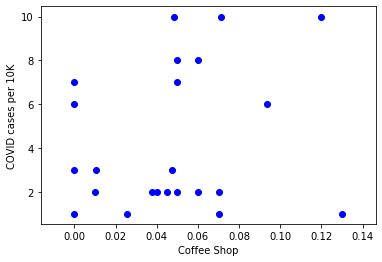

In [40]:
plt.scatter(sf_grouped['Coffee Shop'], sfcovid_df['group_id'], color='blue')
plt.xlabel('Coffee Shop')
plt.ylabel('COVID cases per 10K')
plt.show()

<p>The graph doesn't suggest any linear relationship. Therefore, let's try another popular category, Bar:</p>

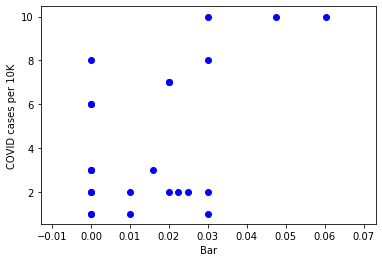

In [41]:
plt.scatter(sf_grouped['Bar'], sfcovid_df['group_id'], color='blue')
plt.xlabel('Bar')
plt.ylabel('COVID cases per 10K')
plt.show()

<p>Hmmm... Still no obvious correlation can be suggested by this graph.</p>
<p>COVID-19 has a disportionally greate effects minority and poor populations, and these tend to live in neighborhoods that are "food islands", meaning they often lack grocery store. We will see if Grocery Store category has any correlation:

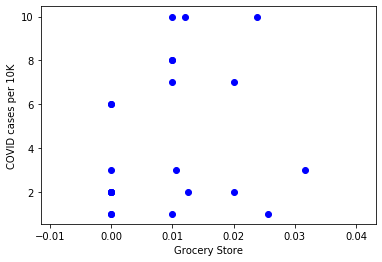

In [42]:
plt.scatter(sf_grouped['Grocery Store'], sfcovid_df['group_id'], color='blue')
plt.xlabel('Grocery Store')
plt.ylabel('COVID cases per 10K')
plt.show()

<p>Obviously, none of the above categories has any correlation to COVID-19 case counts. We should see if other categories show any correlation. However, with more than 270 categories, it is impossible to go through them one by one manually to see if there is any category that correlates to COVID-19 case counts. Therefore, we will write a function to generate a linear regression model for each category and find the model's Mean Absolute Error, Mean Squared Error (MSE), and R-Squared (R2-score), and pass each category to that function, then store the results in a dataframe.</p>

In [43]:
#define a function that return Mean Absolute Error, Mean Squared Error (MSE), and R-Squared (R2-score) of a linear regression model
def return_linear_mod_results(X, Y, x_col, t_size):
    
    #split the data sets into train sets and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=t_size, random_state=4)
    
    #create a linear regression model and fit test set into the model
    regr = linear_model.LinearRegression()
    train_x = np.asanyarray(X_train[[x_col]])
    train_y = np.asanyarray(Y_train[['group_id']])
    regr.fit (train_x, train_y)
    
    #predict results with model
    test_x = np.asanyarray(X_test[[x_col]])
    test_y = np.asanyarray(Y_test[['group_id']])
    test_y_hat = regr.predict(test_x)
    
    #find Mean Absolute Error, Mean Squared Error (MSE), and R-Squared (R2-score) of the model
    mae = np.mean(np.absolute(test_y_hat - test_y))
    mse = np.mean((test_y_hat - test_y) ** 2)
    r2= r2_score(test_y_hat , test_y) 
    
    #return the 3 metrics
    return [mae, mse, r2]

In [44]:
#find the dependent variable (results) sets
y = sfcovid_df['group_id'].to_frame()

#generate a list of venue categories
col_list = list(sf_grouped.columns)

#create a new dataframe to store metric results of linear regression model for each category
ln_mod_results = pd.DataFrame(columns=('Venue','Mean absolute error','MSE','R2-score'))

#iterate through category list, find the independent variables, and call function above to get metrics
#linear regression model
for col in col_list[1:]: #skip first column as it is neighborhood
    x = sf_grouped[col].to_frame()
    results = return_linear_mod_results(x,y,col,testsize)
    ln_mod_results= ln_mod_results.append({'Venue':col,
                                          'Mean absolute error':results[0],
                                          'MSE':results[1],
                                          'R2-score':results[2]},
                                          ignore_index=True)

#display the first few rows of metrics results
ln_mod_results.head()

,Venue,Mean absolute error,MSE,R2-score
0,ATM,2.625000,7.733073,0.000000
1,Accessories Store,4.775641,29.341469,-2.398234
2,Adult Boutique,2.822222,8.671111,0.000000
3,African Restaurant,2.958333,9.420573,0.000000
4,Alternative Healer,2.777778,8.444444,0.000000


<p>Let's sort the R2-score to see if there are any positive correlation:</p>

In [45]:
#sort results by R2-score field
ln_mod_results = ln_mod_results.sort_values(by=['R2-score'], ascending=False)
ln_mod_results.head(10)

,Venue,Mean absolute error,MSE,R2-score
169,Mountain,3.500000,15.744792,0.104296
160,Middle Eastern Restaurant,2.976458,10.978351,0.072928
221,Scenic Lookout,4.042901,19.744010,0.072554
5,American Restaurant,3.812349,21.394497,0.070947
191,Pedestrian Plaza,2.866667,8.906667,0.000000
190,Parking,2.958333,9.420573,0.000000
108,General Entertainment,3.000000,9.666667,0.000000
188,Paper / Office Supplies Store,2.636152,7.781446,0.000000
252,Tennis Court,2.841402,8.771671,0.000000
111,Gourmet Shop,3.000000,9.666667,0.000000


<p>As we can see, as the highest R2-score is 0.104 (for Mountain, of all the venue categories...), there is no category that has meaningful positive correlation to COVID-19 case counts. <br>
    We will then see if there is any category that has an inverse correlation. We do this by fitering R2-score values between -1.2 and -0.8:</p>

In [46]:
#filter rows with R2-score values between -1.1 and -0.9
ln_mod_results_rev_negcorr = ln_mod_results[ln_mod_results['R2-score'].between(-1.2,-0.8)]
ln_mod_results_rev_negcorr

,Venue,Mean absolute error,MSE,R2-score
262,Tree,2.206979,5.803123,-0.960189


<p>The results are interesting. Of all venue categories, Tree has very high inverse correlation! Let's generate a scatter plot to see what this inverse correlation looks like:</p>

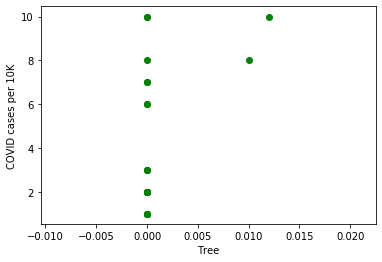

In [47]:
plt.scatter(sf_grouped['Tree'], sfcovid_df['group_id'], color='green')
plt.xlabel('Tree')
plt.ylabel('COVID cases per 10K')
plt.show()

<p>The graph above cannot substantiate inverse correlations between Tree and COVID-19 case counts (as if we need any data analysis or plotting to tell us that.) There are 22 neighborhoods (or zip codes) in the data set, but only 2 neighborhoods had Tree in their venue categories, meaning a majority of neighborhoods did not have any Tree rankings. </p>
<p>Does this mean majority of neighborhoods in San Francisco do not have trees? No, it is fairly obvious that most people do not rate trees online, so there is a lack of ranking data for categories like Tree.</p>


<h4><u>Conclusion for Linear Regression data modeling:</u></h4>
<p>We cannot establish that any of the venue categories downloaded from Foursquare has a positive or inverse correlation with San Francisco's COVID-19 case counts. This should not come as a huge surprise, as ranking data collected by geo-location data aggregation companies such as Foursquare tends to focus more on places like restaurants and retail shops, and such rankings are not likely to have significant correlation with public health statistics.</p>
<br>

<h3>Data Modeling - K-Nearest Neighbors</h3>
<p>Though linear regression model did not work out, we will proceed with K-Nearest Neighbors (KNN) models to see if we can find any significant correlation between venue categories and COVID-19 case counts.<p>
<p>First, let find all venue categories from the entire data set, sort them by frequency of appearance, and put them in a list:</p>

In [48]:
#for all venue categories and  sort them by frequency
categories_sorted = sf_venues['Venue Category'].value_counts().sort_values(ascending=False)

#display the list
categories_sorted[:10]

Coffee Shop             93
Park                    65
Café                    55
Pizza Place             44
Gym                     34
Bakery                  33
Italian Restaurant      33
Gym / Fitness Center    32
Bar                     32
Sandwich Place          27
Name: Venue Category, dtype: int64

<p>We then define the dependent variable data set.</p>

In [49]:
#find the dependent variable (results) sets
Y = sfcovid_df['group_id'].values

#display first 5 values
Y[0:5]

array([1., 2., 7., 8., 1.])

<p>For KNN modeling, we would like to generate 3 different models with different numbers of independent variables. Specifically, we want to model with top 4 independent variable, top 8 independent variables, and top 12 independent variables. To do this, we first create a function to generate independent variable data set based on data sets and parameters passed to this function.</p>

In [50]:
#define a function to return data set for a number of independent variable 
def return_df_by_venue_category(cat_sorted, grouped_data, num):
    
    #generate a list for specific number of categories 
    add_list = cat_sorted[:num].index.tolist()
    
    #create a dataframe to house the data set
    top_data_grouped = pd.DataFrame(columns = add_list)
    
    #populate dataframe
    top_data_grouped[add_list] = grouped_data[add_list]
    
    return top_data_grouped

<p>For the first KNN model, we create an independent variable data set for top 4 venue categories.</p>

In [51]:
#define number of category to generate dataframe
num_cat = 4

#call function to generate dataframe of independent variables
top_4_cat = return_df_by_venue_category(cat_sorted=categories_sorted,
                                                  grouped_data=sf_grouped,
                                                  num=num_cat)
#display dataframe
top_4_cat

,Coffee Shop,Park,Café,Pizza Place
0,0.000000,0.095238,0.095238,0.000000
1,0.050000,0.050000,0.010000,0.000000
2,0.050000,0.020000,0.050000,0.010000
3,0.060000,0.060000,0.060000,0.020000
4,0.130000,0.020000,0.030000,0.010000
5,0.060000,0.050000,0.040000,0.050000
6,0.070000,0.020000,0.010000,0.020000
7,0.037500,0.012500,0.012500,0.062500
8,0.093750,0.125000,0.062500,0.031250
9,0.010000,0.050000,0.010000,0.010000


<p>We then normalize the data.</p>

In [52]:
#use StandardScaler to normalize independent variables
X = preprocessing.StandardScaler().fit(top_4_cat).transform(top_4_cat.astype(float))

#display first 5 set of values
X[0:5]

array([[-1.34479292,  0.8052657 ,  2.5712085 , -1.21568739],
       [ 0.07439828, -0.04325534, -0.8641893 , -1.21568739],
       [ 0.07439828, -0.60595877,  0.74795268, -0.69345349],
       [ 0.35823652,  0.14431246,  1.15098818, -0.17121959],
       [ 2.3451042 , -0.60595877, -0.05811831, -0.69345349]])

<p>Now that both dependent and independent variables are ready, we can split them into train and test sets, and display their sizes.</p>

In [53]:
#split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=testsize, random_state=4)

#display train/test set data shape
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (17, 4) (17,)
Test set: (6, 4) (6,)


<p>We then generate KNN models for K from 1 to 10, and store each models mean and standard deviation in arrays.</p>

In [54]:
#define # of Ks to iterate
Ks = 10

#create numpy arrays to house house standard deviations and means
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

#iterate through K's to train and predict KNN model
for n in range(1,Ks):
    
    #train model and predict based on model
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    Yhat=neigh.predict(X_test)
    
    #calcualte mean and standard deviation of the model
    mean_acc[n-1] = metrics.accuracy_score(Y_test, Yhat)
    std_acc[n-1]=np.std(Yhat==Y_test)/np.sqrt(Yhat.shape[0])

#display mean values
mean_acc

array([0.        , 0.        , 0.        , 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667])

<p>We plot the means and standard deviations on a graph to visualize the model performance.</p>

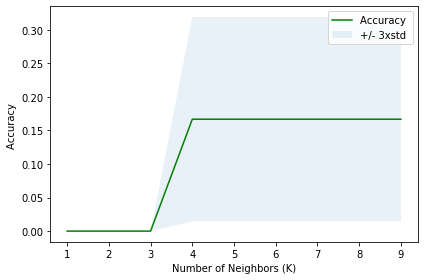

In [55]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

<p>With K from 4 to 9, the mean is 0.1667, indicating that this model is performing optimally.</p>
<p>We will proceed with top 8 categories next and train another set of KNN models with the same steps above.</p>

In [56]:
#define number of category to generate dataframe
num_cat = 8

#call function to generate dataframe of independent variables
top_8_cat = return_df_by_venue_category(cat_sorted=categories_sorted,
                                                  grouped_data=sf_grouped,
                                                  num=num_cat)
#display dataframe
top_8_cat

,Coffee Shop,Park,Café,Pizza Place,Gym,Bakery,Italian Restaurant,Gym / Fitness Center
0,0.000000,0.095238,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.050000,0.050000,0.010000,0.000000,0.020000,0.020000,0.000000,0.010000
2,0.050000,0.020000,0.050000,0.010000,0.010000,0.010000,0.050000,0.030000
3,0.060000,0.060000,0.060000,0.020000,0.000000,0.000000,0.000000,0.000000
4,0.130000,0.020000,0.030000,0.010000,0.060000,0.000000,0.000000,0.030000
5,0.060000,0.050000,0.040000,0.050000,0.000000,0.050000,0.070000,0.010000
6,0.070000,0.020000,0.010000,0.020000,0.030000,0.020000,0.010000,0.010000
7,0.037500,0.012500,0.012500,0.062500,0.000000,0.037500,0.000000,0.000000
8,0.093750,0.125000,0.062500,0.031250,0.125000,0.000000,0.000000,0.000000
9,0.010000,0.050000,0.010000,0.010000,0.020000,0.000000,0.040000,0.060000


In [57]:
#use StandardScaler to normalize independent variables
X = preprocessing.StandardScaler().fit(top_8_cat).transform(top_8_cat.astype(float))

#display first 5 set of values
X[0:5]

array([[-1.34479292,  0.8052657 ,  2.5712085 , -1.21568739, -0.66867197,
        -0.88027607, -0.70565259, -0.80289394],
       [ 0.07439828, -0.04325534, -0.8641893 , -1.21568739,  0.02771964,
         0.24095305, -0.70565259, -0.24624642],
       [ 0.07439828, -0.60595877,  0.74795268, -0.69345349, -0.32047617,
        -0.31966151,  1.63647048,  0.86704862],
       [ 0.35823652,  0.14431246,  1.15098818, -0.17121959, -0.66867197,
        -0.88027607, -0.70565259, -0.80289394],
       [ 2.3451042 , -0.60595877, -0.05811831, -0.69345349,  1.42050286,
        -0.88027607, -0.70565259,  0.86704862]])

In [58]:
#split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=testsize, random_state=4)

#display train/test set data shape
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (17, 8) (17,)
Test set: (6, 8) (6,)


In [59]:
#define # of Ks to iterate
s = 10

#create numpy arrays to house house standard deviations and means
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

#iterate through K's to train and predict KNN model
for n in range(1,Ks):
    
    #train model and predict based on model  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    Yhat=neigh.predict(X_test)
    
    #calcualte mean and standard deviation of the model
    mean_acc[n-1] = metrics.accuracy_score(Y_test, Yhat)
    std_acc[n-1]=np.std(Yhat==Y_test)/np.sqrt(Yhat.shape[0])

#display mean values    
mean_acc

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667])

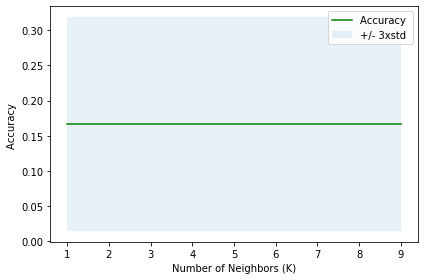

In [60]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

<p>The mean for KNN models for top 8 venue categories as independent variables are at a constant 0.1667, showing no improvement from previous model set.</p>
<p>We will move on with our final KNN models with top 12 venue categories as independent variables.</p>

In [61]:
#define number of category to generate dataframe
num_cat = 12

#call function to generate dataframe of independent variables
top_12_cat = return_df_by_venue_category(cat_sorted=categories_sorted,
                                                  grouped_data=sf_grouped,
                                                  num=num_cat)
#display dataframe
top_12_cat

,Coffee Shop,Park,Café,Pizza Place,Gym,Bakery,Italian Restaurant,Gym / Fitness Center,Bar,Sandwich Place,Yoga Studio,New American Restaurant
0,0.000000,0.095238,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000
1,0.050000,0.050000,0.010000,0.000000,0.020000,0.020000,0.000000,0.010000,0.000000,0.010000,0.020000,0.030000
2,0.050000,0.020000,0.050000,0.010000,0.010000,0.010000,0.050000,0.030000,0.020000,0.010000,0.020000,0.000000
3,0.060000,0.060000,0.060000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.000000
4,0.130000,0.020000,0.030000,0.010000,0.060000,0.000000,0.000000,0.030000,0.010000,0.010000,0.020000,0.010000
5,0.060000,0.050000,0.040000,0.050000,0.000000,0.050000,0.070000,0.010000,0.000000,0.010000,0.020000,0.030000
6,0.070000,0.020000,0.010000,0.020000,0.030000,0.020000,0.010000,0.010000,0.010000,0.020000,0.010000,0.010000
7,0.037500,0.012500,0.012500,0.062500,0.000000,0.037500,0.000000,0.000000,0.025000,0.037500,0.000000,0.012500
8,0.093750,0.125000,0.062500,0.031250,0.125000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000
9,0.010000,0.050000,0.010000,0.010000,0.020000,0.000000,0.040000,0.060000,0.020000,0.020000,0.030000,0.010000


In [62]:
#use StandardScaler to normalize independent variables
X = preprocessing.StandardScaler().fit(top_12_cat).transform(top_12_cat.astype(float))

#display first 5 set of values
X[0:5]

array([[-1.34479292,  0.8052657 ,  2.5712085 , -1.21568739, -0.66867197,
        -0.88027607, -0.70565259, -0.80289394, -0.9761385 ,  2.52033126,
        -1.041314  , -0.83153779],
       [ 0.07439828, -0.04325534, -0.8641893 , -1.21568739,  0.02771964,
         0.24095305, -0.70565259, -0.24624642, -0.9761385 , -0.45481365,
         0.74770309,  1.31209407],
       [ 0.07439828, -0.60595877,  0.74795268, -0.69345349, -0.32047617,
        -0.31966151,  1.63647048,  0.86704862,  0.2334998 , -0.45481365,
         0.74770309, -0.83153779],
       [ 0.35823652,  0.14431246,  1.15098818, -0.17121959, -0.66867197,
        -0.88027607, -0.70565259, -0.80289394, -0.9761385 , -0.45481365,
         0.74770309, -0.83153779],
       [ 2.3451042 , -0.60595877, -0.05811831, -0.69345349,  1.42050286,
        -0.88027607, -0.70565259,  0.86704862, -0.37131935, -0.45481365,
         0.74770309, -0.11699384]])

In [63]:
#split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=testsize, random_state=4)

#display train/test set data shape
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (17, 12) (17,)
Test set: (6, 12) (6,)


In [64]:
#define # of Ks to iterate
Ks = 10

#create numpy arrays to house house standard deviations and means
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))


#iterate through K's to train and predict KNN model
for n in range(1,Ks):
    
    #train model and predict based on model  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    Yhat=neigh.predict(X_test)

    #calcualte mean and standard deviation of the model
    mean_acc[n-1] = metrics.accuracy_score(Y_test, Yhat)
    std_acc[n-1]=np.std(Yhat==Y_test)/np.sqrt(Yhat.shape[0])

#display mean values    
mean_acc

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667])

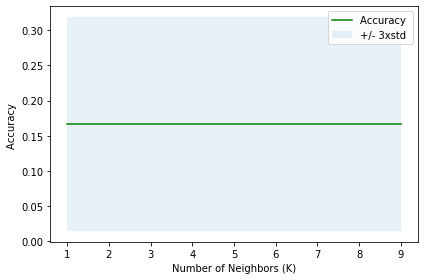

In [65]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

<p>It looks like there is no improvement in the modeling accuracy going from 8 to 12 independent variables.</p>

<h4><u>Conclusion for K-Nearest Neighbors (KNN) data modeling:</u></h4>
<p>As with linear regression modeling, we also cannot establish a KNN model that has good accuracy for predicting SF COVID-19 case counts from venue categories. The reason for this is likely the same as that provided for linear regression model above.</p>
<br>

<h3>Analysis Conclusion:</h3>
<p><strong>For this project, we performed the following steps:</strong></p>
<ul><b>
    <li>Downloaded relevant data from various websites/sources</li>
    <li>Wrangled the data in formats needed for analysis and modeling</li>
    <li>Performed exploratory data analysis and visualization</li>
    <li>Generated Linear Regression models and analyzed the results</li>
    <li>Generated K-Nearest Neighbors models and analyzed the results</li>   
</b></ul>


<p><strong>As mentioned above in conclusion sections of the two data modeling techniques, we were not able to find correlation between San Francisco's COVID-19 case count by zip code and neighbor venue category data from Foursquare. This should come as no surprise to us. Data aggregated by companies like Foursquare are more geared toward commercial establishments, such as retail stores, tourist attractions, and restaurants/bars. Rankings of these places seldom correlate with public health statistics. Demographic data such as income, age, and/or ethnicity distribution may correlate with public health data in more significant and meaningful ways. </strong></p>